In [47]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import scipy.linalg as la
import seaborn as sns
sns.set_theme()

## Classic Tri-lateration for single magnet trial

### i). Choose sensor deployment location

Given the table is rectangular shape(with dimension as [length=alpha, width=beta] in 2d), we can fix one corner as the origin, the other as [0, beta].

In [34]:
# set the length and width of the rectangular shape table 
[alpha, beta] = [76.0, 50.5]

# anchor 0 is the origin point
Anchor_0 = [0.0, 0.0]
# anchor 1 is directly on top of anchor 0
Anchor_1 = [0.0, beta]
# anchor 2 is at the center
Anchor_2 = [alpha/2, beta/2]

### ii). Choose magnet type and conclude its decay function

* Pick Alcomax PRM as the first step experimental magnet because of its medium size, cylindrical shape of 16mm length with 8mm diameter.
* Designed a decay function to fit the field strength decay of PRM, thought of using a single log function to simulate the correlation but feels the piece-wise function could make more sense and simulate at a better accuracy, separation point of the piece-wise function is determined by so-called coefficient of determination($R^{2}$), for a best fit line.

In [35]:
# these are the sampled field strength (in mV level) with respect to distance (in centi-meter)

# We use +- 6V range of ADS1115 external 16-bit ADC with the resolution as 0.1875mV per each digital bit

x_values = np.array([
    1032.75, 555.75, 312.1875, 202.6875, 135.0, 94.6875, 68.625, 51.5625,
    38.8125, 30.375, 24.375, 19.6875, 16.6875, 13.5, 11.4375, 9.75, 8.0625,
    7.3125, 6.375, 6.0, 5.4375, 4.3125, 3.75, 3.0, 2.625, 2.4375, 1.875
])

y_values = np.array([
    4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30
])

* Here we simulate the larger magnet AlCoMax-PRMM, with cylindrical shape of 30mm length and 10 mm diameter.
* Same method as above to fit a strength-distance correlation function

In [36]:
import pandas as pd
magnet_corr_data = pd.read_csv("./data/mar-27-prlm-prm-prmm-strength-dist-corr-re-gather/mar-27-prm-6-1.0cm-resolution-corr-regather.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])["anchor_0"]

In [37]:
np.array(magnet_corr_data)
zero_indices = np.where(magnet_corr_data == 0)[0]
zero_indices
split_arrays = np.split(magnet_corr_data, zero_indices)
len(split_arrays)
# 33 needs to be removed
split_arrays[-1]


2342    0.0
Name: anchor_0, dtype: float64

In [38]:
mean_val_array = [np.mean(split_arrays[0])]
for indx in range(1, len(split_arrays)):
    if (indx != len(split_arrays) - 1):
        mean_val_array.append(np.mean(split_arrays[indx][20:]))
mean_val_array

[2847.433227528571,
 3292.425288156862,
 3157.2702205686282,
 3067.8633769607836,
 3006.466691490196,
 2964.577789882353,
 2937.092706411765,
 2916.2289704117647,
 2901.5444767058816,
 2890.3587670392158,
 2882.3552915490186,
 2875.8701458431374,
 2871.221373352941,
 2867.3078900980386,
 2864.319766764706,
 2862.070441725491,
 2860.497721313726,
 2859.389562235294,
 2858.707280215686,
 2857.659658372549,
 2856.3122750392154,
 2854.850155117648,
 2853.863697745097,
 2852.8344008431372,
 2852.2866067254895,
 2851.764997882353,
 2851.234188294118,
 2850.931841627451,
 2850.6797019215683,
 2850.2669892352947,
 2850.1931534705886,
 2849.8426346274505,
 2847.5091863921575]

In [39]:
strength_deltas = mean_val_array[1:-1] - mean_val_array[0]
distances = np.linspace(5, 5+len(strength_deltas)-1, len(strength_deltas))
print(strength_deltas)
print(distances)
print(len(distances))
print(len(strength_deltas))

[444.99206063 309.83699304 220.43014943 159.03346396 117.14456235
  89.65947888  68.79574288  54.11124918  42.92553951  34.92206402
  28.43691831  23.78814582  19.87466257  16.88653924  14.6372142
  13.06449379  11.95633471  11.27405269  10.22643084   8.87904751
   7.41692759   6.43047022   5.40117331   4.8533792    4.33177035
   3.80096077   3.4986141    3.24647439   2.83376171   2.75992594
   2.4094071 ]
[ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22.
 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]
31
31


In [40]:
x_values = strength_deltas
y_values = distances

* plot all the sampled data points and visualize with a log function fit.

In [49]:
# fit all to a log function and visualize the logarithmic function's goodness of fit
from scipy.optimize import curve_fit

# Define the logarithmic function
def log_func(x, a, b, c):
    return a + b * np.log(x) + c

# Fit the logarithmic function to the data
popt, _ = scipy.optimize.curve_fit(log_func, x_values, y_values, maxfev=10000)
# Generate the expression of the function to be displayed in the legend
a, b, c = popt
func_expression = f'Log Fit: y = {a:.2f} + {b:.2f} * ln(x) + {c:.2f}'

# Generate a range of x values for plotting the fit function
x_fit = np.linspace(min(x_values), max(x_values), 100)
y_fit = log_func(x_fit, *popt)

plt.figure(figsize=(10, 6), dpi=100)

# do a scatter plot here first to visualize the overall pattern
plt.scatter(x_values, y_values, color='green', label='Data Points', marker="x")

# plot the fitted logarithmic function
plt.plot(x_fit, y_fit, color='red', label= func_expression)

plt.title('Alcomax-PRM on DRV425 fluxgate with ADS1115 sample: Field Strength vs. Distance')
plt.xlabel('Field Strength (millivolts)')
plt.ylabel('Distance (centimeters)')
plt.legend()
plt.show()

NameError: name 'scipy' is not defined

* fit with piecewise log function and visualize.

/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Log Fit: y = 202.46 + -8.13 * ln(x) + -161.09
Log Fit: y = 365.45 + -3.52 * ln(x) + -339.38


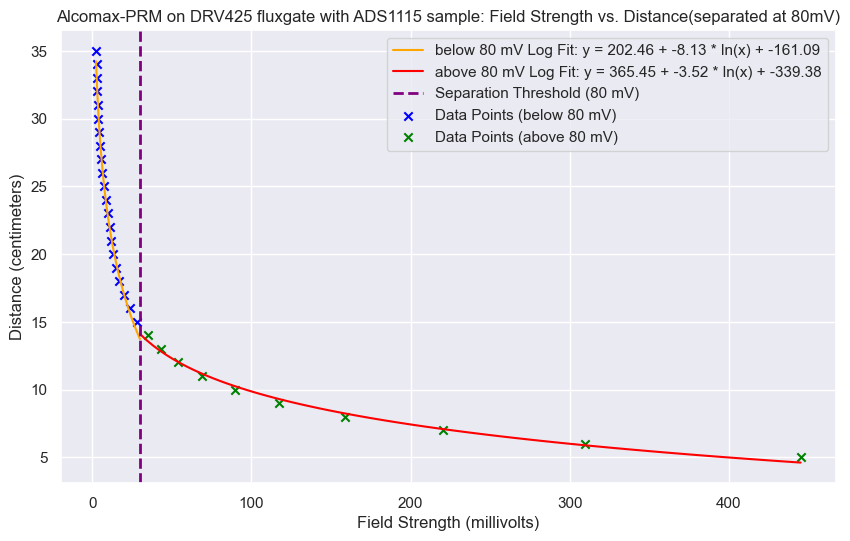

In [50]:
# Fit the logarithmic function to the data below and above the threshold of 80 mV
threshold = 30

below_threshold = x_values < threshold
above_threshold = x_values >= threshold

x_below = x_values[below_threshold]
y_below = y_values[below_threshold]
x_above = x_values[above_threshold]
y_above = y_values[above_threshold]

popt_below_best, _ = curve_fit(log_func, x_below, y_below)
(a_below_best, b_below_best, c_below_best) = popt_below_best
below_func_expression = f'Log Fit: y = {a_below_best:.2f} + {b_below_best:.2f} * ln(x) + {c_below_best:.2f}'

popt_above_best, _ = curve_fit(log_func, x_above, y_above)
(a_above_best, b_above_best, c_above_best) = popt_above_best
above_func_expression = f'Log Fit: y = {a_above_best:.2f} + {b_above_best:.2f} * ln(x) + {c_above_best:.2f}'


# Generate a range of x values for plotting the fit functions
x_fit_below = np.linspace(min(x_values), threshold, 100)
y_fit_below = log_func(x_fit_below, *popt_below_best)

x_fit_above = np.linspace(threshold, max(x_values), 100)
y_fit_above = log_func(x_fit_above, *popt_above_best)

# Plotting the scatter plot of the original data points and the piecewise fit functions
plt.figure(figsize=(10, 6), dpi=100)

# Scatter plot of the original data points
plt.scatter(x_below, y_below, color='blue', label='Data Points (below 80 mV)', marker="x")
plt.scatter(x_above, y_above, color='green', label='Data Points (above 80 mV)', marker="x")

# Plotting the logarithmic fit function for data below the threshold
plt.plot(x_fit_below, y_fit_below, color='orange', label='below 80 mV ' + below_func_expression)
print(below_func_expression)

# Plotting the logarithmic fit function for data above the threshold
plt.plot(x_fit_above, y_fit_above, color='red', label='above 80 mV ' + above_func_expression)
print(above_func_expression)

# Plot the vertical line at x = 80 mV for the separation
plt.axvline(x=threshold, color='purple', linestyle='--', linewidth=2, label='Separation Threshold (80 mV)')

# Add title and labels
plt.title('Alcomax-PRM on DRV425 fluxgate with ADS1115 sample: Field Strength vs. Distance(separated at 80mV)')
plt.xlabel('Field Strength (millivolts)')
plt.ylabel('Distance (centimeters)')
plt.legend()

# Show the plot
plt.show()

In [51]:
from sklearn.metrics import r2_score

# Define a range of potential threshold values to evaluate
threshold_values = np.linspace(20, 100, 121)  # From 80 to 120 mV in steps of 1 mV

# Initialize a dictionary to store R² values for each threshold
r2_results = {}

# Loop over each threshold value and perform piecewise fitting
for threshold in threshold_values:
    # Separate the data at the current threshold
    below_threshold = x_values < threshold
    above_threshold = x_values >= threshold

    x_below = x_values[below_threshold]
    y_below = y_values[below_threshold]
    x_above = x_values[above_threshold]
    y_above = y_values[above_threshold]

    # Fit the logarithmic function to both segments
    if len(x_below) > 0 and len(x_above) > 0:  # Ensure there are data points in both segments
        popt_below_best, _ = curve_fit(log_func, x_below, y_below)
        popt_above_best, _ = curve_fit(log_func, x_above, y_above)

        # Predict values using the fitted models
        y_pred_below = log_func(x_below, *popt_below_best)
        y_pred_above = log_func(x_above, *popt_above_best)

        # Calculate R² for both segments
        r2_below = r2_score(y_below, y_pred_below)
        r2_above = r2_score(y_above, y_pred_above)

        # Store the combined R² in the dictionary
        r2_results[threshold] = (r2_below + r2_above) / 2  # Average of both R² values

# Find the threshold with the highest combined R² value
best_threshold = max(r2_results, key=r2_results.get)
best_r2 = r2_results[best_threshold]

best_threshold, best_r2

/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Cova

(35.33333333333333, 0.9932332072608558)

* visualize the piecewise function again using the best threshold computed.

/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Log Fit: y = 207.27 + -7.97 * ln(x) + -166.17
Log Fit: y = 373.12 + -3.41 * ln(x) + -347.63


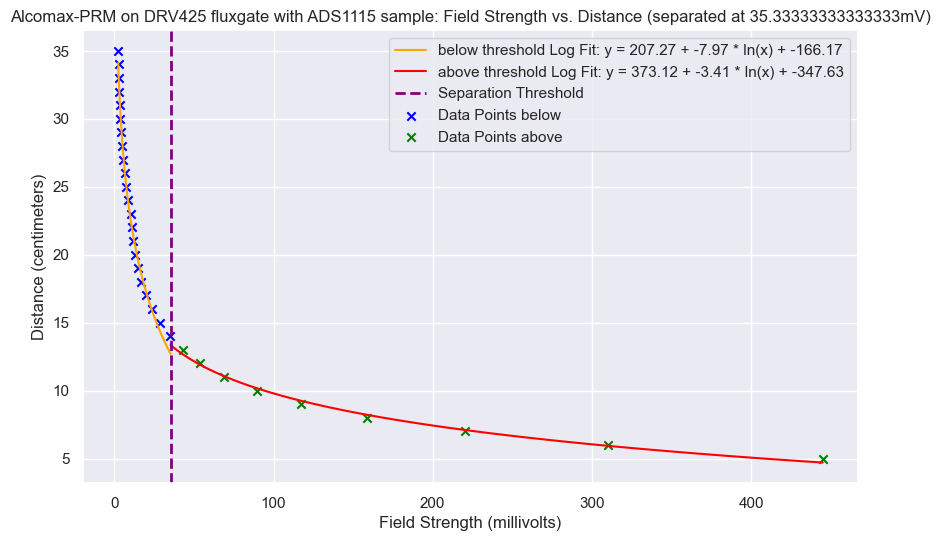

[(207.2712232534118, -7.967425741375843, -166.16626882372043), (373.1220853656233, -3.4096835938461902, -347.6268404634702), 35.33333333333333]


In [52]:
# Fit the logarithmic function to the data below and above the threshold of 52 mV
threshold = best_threshold

below_threshold = x_values < threshold
above_threshold = x_values >= threshold

x_below = x_values[below_threshold]
y_below = y_values[below_threshold]
x_above = x_values[above_threshold]
y_above = y_values[above_threshold]

popt_below_best, _ = curve_fit(log_func, x_below, y_below)
(a_below_best, b_below_best, c_below_best) = popt_below_best
below_func_expression = f'Log Fit: y = {a_below_best:.2f} + {b_below_best:.2f} * ln(x) + {c_below_best:.2f}'
print(below_func_expression)


popt_above_best, _ = curve_fit(log_func, x_above, y_above)
(a_above_best, b_above_best, c_above_best) = popt_above_best
above_func_expression = f'Log Fit: y = {a_above_best:.2f} + {b_above_best:.2f} * ln(x) + {c_above_best:.2f}'
print(above_func_expression)


# Generate a range of x values for plotting the fit functions
x_fit_below = np.linspace(min(x_values), threshold, 100)
y_fit_below = log_func(x_fit_below, *popt_below_best)

x_fit_above = np.linspace(threshold, max(x_values), 100)
y_fit_above = log_func(x_fit_above, *popt_above_best)

# Plotting the scatter plot of the original data points and the piecewise fit functions
plt.figure(figsize=(10, 6), dpi=100)

# Scatter plot of the original data points
plt.scatter(x_below, y_below, color='blue', label='Data Points below', marker="x")
plt.scatter(x_above, y_above, color='green', label='Data Points above', marker="x")

# Plotting the logarithmic fit function for data below the threshold
plt.plot(x_fit_below, y_fit_below, color='orange', label='below threshold ' + below_func_expression)

# Plotting the logarithmic fit function for data above the threshold
plt.plot(x_fit_above, y_fit_above, color='red', label='above threshold ' + above_func_expression)

# Plot the vertical line at x = 80 mV for the separation
plt.axvline(x=threshold, color='purple', linestyle='--', linewidth=2, label='Separation Threshold')

# Add title and labels
plt.title(f'Alcomax-PRM on DRV425 fluxgate with ADS1115 sample: Field Strength vs. Distance (separated at {threshold}mV)')
plt.xlabel('Field Strength (millivolts)')
plt.ylabel('Distance (centimeters)')
plt.legend()

# Show the plot
plt.show()

cur_magnet_profile = [(a_below_best, b_below_best, c_below_best), (a_above_best, b_above_best, c_above_best), threshold]
print(cur_magnet_profile)

### iii). Design algorithm for the detection

Multilateration involves finding the position of a point based on known distances to several other points (in this case, for simplicity, two points). The fundamental principle used here is the geometric fact that the distance between two points can be described by the equation of a circle (in 2D):

$$ (x - x_i)^2 + (y - y_i)^2 = d_i^2 $$

Where $(x, y)$ is the unknown point, $(x_i, y_i)$ is a known point, and $d_i$ is the distance from the unknown point to the known point.

If you expand this equation, you get:

$$ x^2 - 2xx_i + x_i^2 + y^2 - 2yy_i + y_i^2 = d_i^2 $$

To simplify the equations and make them linear, we can subtract one circle's equation from another. This subtraction eliminates the $x^2$ and $y^2$ terms, which are the same for all equations. Doing this for two points, we get a system of linear equations:

$$ -2xx_1 + x_1^2 -2yy_1 + y_1^2 - (-2xx_2 + x_2^2 - 2yy_2 + y_2^2) = d_1^2 - d_2^2 $$

Rearranging terms and simplifying, we get:

$$ 2(x_2 - x_1)x + 2(y_2 - y_1)y = d_1^2 - d_2^2 + x_2^2 - x_1^2 + y_2^2 - y_1^2 $$

This is now a linear equation in terms of $x$ and $y$ (the coordinates of the unknown point), which we can write as:

$$ A \cdot x = b $$

Here, $A$ is the matrix of coefficients, $x$ is the vector containing the unknowns $x$ and $y$, and $b$ is the constant vector.




Matrix \( A \) will contain the coefficients for \( x \) and \( y \) from the linear equations:

$$
A = \begin{bmatrix}
2(x_2 - x_1) & 2(y_2 - y_1) \\
2(x_3 - x_1) & 2(y_3 - y_1)
\end{bmatrix}
$$

Vector \( B \) will contain the constants from the right side of the linear equations:

$$
B = \begin{bmatrix}
d_2^2 - d_1^2 - x_2^2 - y_2^2 + x_1^2 + y_1^2 \\
d_3^2 - d_1^2 - x_3^2 - y_3^2 + x_1^2 + y_1^2
\end{bmatrix}
$$

The unknown vector \( X \) is:

$$
X = \begin{bmatrix}
x \\
y
\end{bmatrix}
$$

This system can be solved using a least squares approach if the equations are independent (which they should be if the three known points are not collinear). If there are more than three points, \( A \) will have more rows, one for each additional point, and \( B \) will have corresponding additional elements, making the system over-determined. In such cases, the least squares solution will minimize the sum of squared residuals.


To solve for $x$, we would normally use matrix inverse or some other direct method, but because we are solving via least squares (which accounts for potential measurement errors and over-determined systems), we use `np.linalg.lstsq`. This function will find the vector $x$ that minimizes the residual sum of squares between the observed outcomes in $b$ and the outcomes predicted by the linear approximation defined by $A$.

In [53]:
def calculate_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.

    Args:
    point1 (array-like): The coordinates of the first point (x, y).
    point2 (array-like): The coordinates of the second point (x, y).

    Returns:
    float: The Euclidean distance between the two points.
    """
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [266]:
def compute_distance(strength_val, below_corr, above_corr, threshold_division):
    """
    Computes the distance from a sensor to a magnet based on the magnet's field strength.

    This function uses a piecewise logarithmic function to convert the field strength 
    measured in millivolts to a distance. Different parameters are used for the logarithmic 
    function depending on whether the field strength is above or below a specified threshold. 
    This accounts for potential non-linearity in the sensor's response at different field strengths.

    Args:
        strength_val (float): The field strength of the magnet measured in millivolts.

    Returns:
        float: The estimated distance from the sensor to the magnet.
    """
    # print(below_corr)
    # print(above_corr)
    (a_below_best, b_below_best, c_below_best) = below_corr
    (a_above_best, b_above_best, c_above_best) = above_corr

    # Check if the field strength is below the threshold.
    # If so, use the logarithmic function parameters for values below the threshold.
    if strength_val < threshold_division:
        return log_func(strength_val, a_below_best, b_below_best, c_below_best)

    # If the field strength is above the threshold,
    # use the logarithmic function parameters for values above the threshold.
    elif strength_val >= threshold_division:
        return log_func(strength_val, a_above_best, b_above_best, c_above_best)

#### All magnet profiles

* PRLM-1:
    * 1.0cm resolution: [(-110.77590098097235, -8.643075277236452, 141.4774630824354), (-250.7193202210314, -3.6829848225262793, 271.891114221628), 7]
* PRM-1: 
    * 0.5cm resolution: [(181.92, -6.8, -147.93), (333.43, -3.41, -309.46), 20]   => residual error: 2.6800 1.7700 => 2-norm distance: ~1.05cm
    * 1.0cm resolution: [(-17.96, -6.11, 51.62), (-392.27, -2.20, 411.23), 51.67] => residual error: 0.1812 0.0226 => 2-norm distance: ~1.33cm
    * 1.0cm re-gathering: [(179.24, -7.94, -142.11), (22.79, -3.41, 1.0), 21.667]
* PRM-2:
    * 1.0cm resolution: [(197.32, -7.63, -158.86), (-341.75, -3.25, 365.68), 34.167]

* PRMM-1: 
    * 1.0cm resolution-1st trial: [(291.41, -8.74, -235.86), (442.58, -3.71, -409.98), 80.0] => residual error: 897.2895 919.9117 => 2-norm distance: ~4.46cm



In [267]:
# Log Fit: y = -155.86 + -8.53 * ln(x) + 197.36
# Log Fit: y = -333.70 + -3.46 * ln(x) + 359.18
# 25.8333333

def localize(Anchor_position_ls, Anchor_reading_ls, cur_indx, place_or_remove):
    """
    Function to carry out naive localization technique utilizing Trilateration for multiple anchors.

    Args: 
        Anchor_position_ls: List of tuples with all anchor positions in order (x, y).
        Anchor_reading_ls: List of all sensory values from all anchor points(sensors), order in accordance to Anchor_position_ls.

    Returns:
        to_return: normal or abnormal case analysis
            normal: Estimated position (point: {x, y}) representing the position of the magnet.
            abnormal: -1 
    """
    print(Anchor_position_ls)
    print(Anchor_reading_ls)
    # "PRM": [(-17.96, -6.11, 51.62), (-392.27, -2.20, 411.23), 51.67]
    # "PRLM-1": [(-107.59, -8.79, 138.39), (265.52, -3.78, -243.97), 6],
    magnet_profiles = {
                       "PRLM-1": prlm_1_profile,
        
                       "PRM-1": prm_1_profile, 
#                        "PRM-2": prm_2_profile,
#                        "PRM-3": prm_3_profile,
#                        "PRM-4": prm_4_profile,
#                        "PRM-5": prm_5_profile,
#                        "PRM-6": prm_6_profile,

                       "PRMM-1": prmm_1_profile}
    

    # Define the logarithmic function
    def log_func(x, a, b, c):
        return a + b * np.log(x) + c
    
    def euclidean_dist(point1, point2):
        difference = np.array(point1) - np.array(point2)
        distance = np.sqrt(np.sum(difference ** 2))
        return distance

    # sensor position list need to be ordered same as estimated distances list
    def compute_residual_error(predicted_location, sensor_positions, observation_distances):
        
        
        
        estimation_distance = []
        for sensor_position in sensor_positions:
            estimation_distance.append(euclidean_dist(predicted_location, sensor_position))
            
        print(f"estimation_distances: {estimation_distance}")
        print(f"observation_distances: {observation_distances}")
        
                                      
        residual_error = sum((euclidean_dist(predicted_location, sensor_position) - observation_distances) ** 2
                             for sensor_position, observation_distances in zip(sensor_positions, observation_distances))
        return residual_error

    # default return is abnormal
    to_return = -1
    
    # initialize an error dictionary for storing distance comparison residual error,
    # formatted as {"magnet_type": (predicted_position, prediction_residual)}
    prediction_result_dict = {"timestamp": cur_indx, "action": place_or_remove}

    # Ensure there are at least three anchors &&
    # Ensure the length of anchor position list equals to the length of anchor reading list
    if len(Anchor_position_ls) < 3 or len(Anchor_position_ls) != len(Anchor_reading_ls): return to_return

    # Successfully go into the evaluation process
    # pull out all magnets info
    magnet_names = magnet_profiles.keys()

    # loop through all magnet profiles
    for each_magnet in magnet_names:
        # Convert sensor readings to distances
        distances = [compute_distance(reading, magnet_profiles[each_magnet][0], magnet_profiles[each_magnet][1], magnet_profiles[each_magnet][2]) for reading in Anchor_reading_ls]
        # distances = [24, 30, 23, ]
        # Reference anchor (typically the first one)
        ref_anchor = Anchor_position_ls[0]
        ref_dist = distances[0]

        # Construct the Matrix A and vector b
        rows_A = []
        vec_b = []
        for i in range(1, len(Anchor_position_ls)):
            anchor = Anchor_position_ls[i]
            dist = distances[i]
            row = [2 * (anchor[0] - ref_anchor[0]), 2 * (anchor[1] - ref_anchor[1])]
            rows_A.append(row)
            b_value = dist**2 - ref_dist**2 - anchor[0]**2 - anchor[1]**2 + ref_anchor[0]**2 + ref_anchor[1]**2
            vec_b.append(b_value)

        mat_A = np.array(rows_A)
        vec_b = np.array(vec_b)

        # Do the least square solution
        # position, residuals = sp.optimize.nnls(mat_A, vec_b)
        position, residuals, _, _ = la.lstsq(mat_A, vec_b)
        position = -position
        # compute the estimation error
        residual_err = compute_residual_error(position, Anchor_position_ls, distances)
        
        # store the predicted position and corresponding residuals into the prediction_result_dict
        prediction_result_dict[each_magnet + "/pos-x"] = position[0]
        prediction_result_dict[each_magnet + "/pos-y"] = position[1]
        prediction_result_dict[each_magnet + "/predicted-distance"] = np.round(np.array([euclidean_dist(anchor_pos, position) for anchor_pos in Anchor_position_ls]), 4)
        prediction_result_dict[each_magnet + "/observed-distance"] = np.round(np.array(distances), 4)
        prediction_result_dict[each_magnet + "/err"] = residual_err
        
        
        print(f"If Type == '{each_magnet}' \n\tPredicted Position: {position} \n\tResidual Error: {residual_err}")
        
        
        


    # Return the solution or abnormal case
    return prediction_result_dict


In [268]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the logarithmic function for fitting
def log_func(x, a, b, c):
    return a + b * np.log(x) + c

def plot_piecewise_log_functions(data):
    """
    Plots multiple piecewise logarithmic functions based on given data.
    Each item in the data list contains two sets of [a, b, c] parameters
    for the logarithmic function and a threshold value, wrapped in a list
    along with a descriptive variable name.

    Parameters:
    - data: List of lists, where each inner list contains a variable name as a string,
            followed by two tuples of [a, b, c] parameters for the piecewise function,
            and a threshold value.
    """
    
    plt.figure(dpi=250, figsize=(8, 4))  # Adjust figure size and DPI as needed

    # Generate x values from 1 to 200, inclusive, 1 per step
    x_values = np.arange(1, 201, 1)

    for i, profile_ls in enumerate(data):
        # Unpack the variable name, parameter sets, and threshold from the list
        variable_name = profile_ls[0]
        params1, params2, threshold = profile_ls[1][0], profile_ls[1][1], profile_ls[1][2]
                
        # Separate the x_values based on the threshold
        x_values_1 = x_values[x_values <= threshold]
        x_values_2 = x_values[x_values > threshold]
        
        # Calculate the y_values for each piece based on the logarithmic function
        y_values_1 = log_func(x_values_1, *params1)
        y_values_2 = log_func(x_values_2, *params2)
        
        # Plot each piece with the same color but distinguish with different line styles
        # Add label only to the first plot to avoid multiple legend entries for the same magnet
        plt.plot(x_values_1, y_values_1, label=f'{variable_name} piece 1', color=f'C{i}')
        plt.plot(x_values_2, y_values_2, label=f'{variable_name} piece 2', color=f'C{i}', linestyle='--')
        
        # Draw a vertical line at the threshold value without adding a label
        plt.axvline(x=threshold, color=f'C{i}', linestyle=':')
        
    plt.ylim(0, 35)  # Set y-axis limits
    plt.xlabel('Field Strength/mV')
    plt.ylabel('Distance/cm')
    plt.title('Multiple Magnets Profiles')
    plt.legend(loc="upper right", fontsize=6)  # Adjust legend location and font size

    plt.show()  # Display the plot

In [269]:
prlm_1_profile = [(-107.59, -8.79, 138.39), (265.52, -3.78, -243.97), 6]
prm_1_profile = [(179.24, -7.94, -142.11), (22.79, -3.41, 1.0), 21.667]
prm_2_profile = [(197.32, -7.63, -158.86), (-341.75, -3.25, 365.68), 34.167]
prm_3_profile = [(214.98651742257684, -7.498351162532263, -174.54408685144608), (-361.6883696784114, -3.250833230970385, 386.60517953870726), 46.666666666666664]
prm_4_profile = [(-155.8608982234551, -8.532071158012691, 197.35803656673608), (-333.69861387723734, -3.4619469422876747, 359.1839360163904), 26.0]
prm_5_profile = [(-167.04803688932228, -8.006662718960483, 208.3885727606311), (-348.04534273430477, -3.409435688846302, 373.5612903566679), 35.33333333333333]
prm_6_profile = [(207.2712232534118, -7.967425741375843, -166.16626882372043), (373.1220853656233, -3.4096835938461902, -347.6268404634702), 35.33333333333333]
prmm_1_profile = [(291.41, -8.74, -235.86), (442.58, -3.71, -409.98), 80.0]

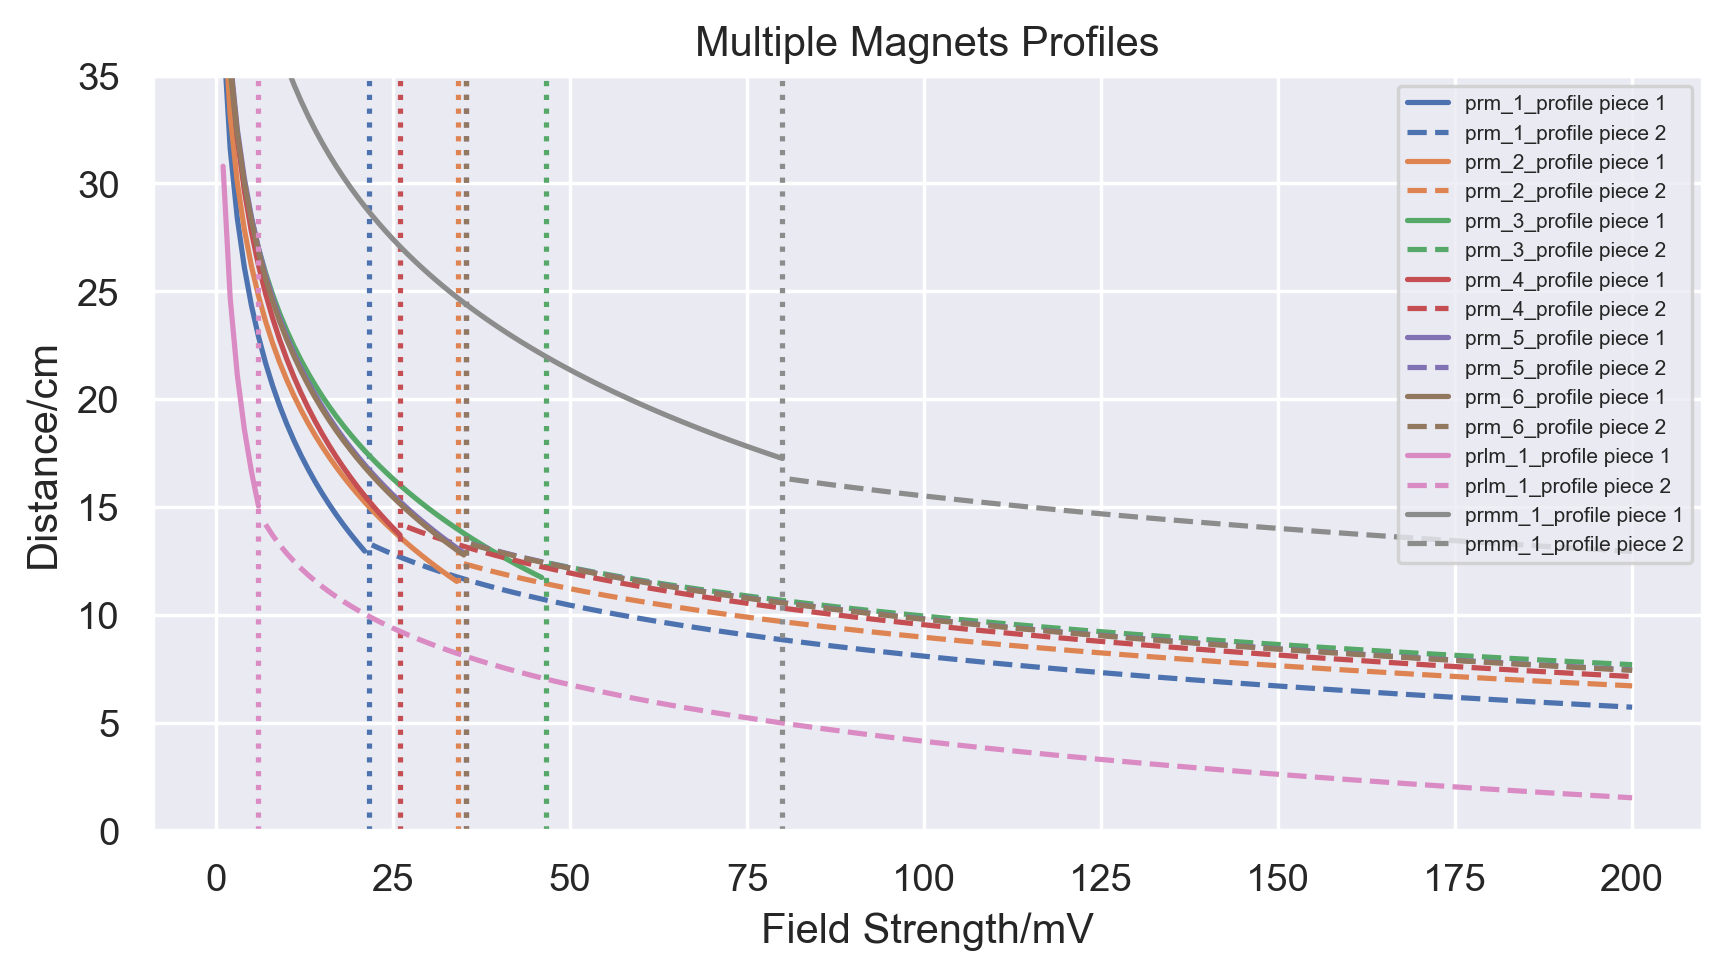

In [270]:
# plot_piecewise_log_functions([ 
#     [(179.24, -7.94, -142.11), (22.79, -3.41, 1.0), 20], 
#     [(197.32, -7.63, -158.86), (-341.75, -3.25, 365.68), 29], 
#     [(214.98651742257684, -7.498351162532263, -174.54408685144608), (-361.6883696784114, -3.250833230970385, 386.60517953870726),40]
# ,   [(-155.8608982234551, -8.532071158012691, 197.35803656673608), (-333.69861387723734, -3.4619469422876747, 359.1839360163904), 24]
# , 
#     [(-167.04803688932228, -8.006662718960483, 208.3885727606311), (-348.04534273430477, -3.409435688846302, 373.5612903566679), 33]
# , 
#     [(207.2712232534118, -7.967425741375843, -166.16626882372043), (373.1220853656233, -3.4096835938461902, -347.6268404634702), 33]
# , 
#     prlm_1_profile, 
#     prmm_1_profile])

plot_piecewise_log_functions([
    ("prm_1_profile", prm_1_profile), 
    ("prm_2_profile", prm_2_profile), 
    ("prm_3_profile", prm_3_profile), 
    ("prm_4_profile", prm_4_profile), 
    ("prm_5_profile", prm_5_profile), 
    ("prm_6_profile", prm_6_profile),
    ("prlm_1_profile", prlm_1_profile),
    ("prmm_1_profile", prmm_1_profile)
])


In [271]:
def plot(data_input, gradients, stability_change_stamps, placement_stamps, removal_stamps):
    
    from matplotlib.ticker import ScalarFormatter

    formatter = ScalarFormatter(useOffset=False)
    
    anchor_name_dict = {0: "anchor_0", 1: "anchor_1", 2: "anchor_2", 3: "anchor_3", 4: "anchor_4"}

    
    # Set up subplots
    fig, axs = plt.subplots(10, 1, figsize=(10, 30), dpi=300)
    
    for indx in range(5):
        
         # Plot original data with placement and removal stamps
        axs[2 * indx].plot(data_input[anchor_name_dict[indx]], label=f'Original Data {anchor_name_dict[indx]}')

        # Initialize the legend handled dictionaries
        legend_handles = {'Placement': False, 'Removal': False}

        for stamp in placement_stamps:
            axs[2 * indx].axvline(x=stamp, color='g', linestyle='--')
            if not legend_handles['Placement']:
                axs[2 * indx].axvline(x=stamp, color='g', linestyle='--', label='Placement')
                legend_handles['Placement'] = True

        for stamp in removal_stamps:
            axs[2 * indx].axvline(x=stamp, color='r', linestyle='--')
            if not legend_handles['Removal']:
                axs[2 * indx].axvline(x=stamp, color='r', linestyle='--', label='Removal')
                legend_handles['Removal'] = True

        axs[2 * indx].set_title(f'Original Data with Event Markers {anchor_name_dict[indx]}')
        axs[2 * indx].set_xlabel('Samples')
        axs[2 * indx].set_ylabel('Field Strength (mV)')
        axs[2 * indx].xaxis.set_major_formatter(formatter)
        axs[2 * indx].yaxis.set_major_formatter(formatter)
        axs[2 * indx].legend(loc="upper right", prop={'size': 6})

        # Plot channel gradient and mark peaks based on correlation
        axs[2 * indx + 1].plot(gradients[indx, :], label=f'Gradient Tracking {anchor_name_dict[indx]}', color="orange")

        legend_handles = {'Placement': False, 'Removal': False}

        for stamp in placement_stamps:
            axs[2 * indx + 1].axvline(x=stamp, color='g', linestyle='--')
            if not legend_handles['Placement']:
                axs[2 * indx + 1].axvline(x=stamp, color='g', linestyle='--', label='Placement')
                legend_handles['Placement'] = True

        for stamp in removal_stamps:
            axs[2 * indx + 1].axvline(x=stamp, color='r', linestyle='--')
            if not legend_handles['Removal']:
                axs[2 * indx + 1].axvline(x=stamp, color='r', linestyle='--', label='Removal')
                legend_handles['Removal'] = True

        axs[2 * indx + 1].set_title(f'Channel Gradient {anchor_name_dict[indx]}')
        axs[2 * indx + 1].set_xlabel('Samples')
        axs[2 * indx + 1].set_ylabel('Gradient (mV/sample)')
        axs[2 * indx + 1].xaxis.set_major_formatter(formatter)
        axs[2 * indx + 1].yaxis.set_major_formatter(formatter)
        axs[2 * indx + 1].legend(loc="upper right", prop={'size': 6})
        
        
        
        
    plt.tight_layout()
    plt.show()
    
    return

    
    

In [274]:

def euclidean_dist(point1, point2):
    difference = np.array(point1) - np.array(point2)
    distance = np.sqrt(np.sum(difference ** 2))
    return distance

In [275]:
def stability_check(derivative_array, thresholds, len_chunks=5):
    
    summed_deri = np.array([])
    # aggregate the gradient sub-arrays for comparison
    for i in range(5):
        summed_deri = np.append(summed_deri, np.sum(np.abs(derivative_array[i*20: i*20 + 20])))
    # print(summed_deri)

    # compared all summed values to thresholds
    if (summed_deri[0] <= thresholds[0] and 
        summed_deri[1] <= thresholds[1] and 
        summed_deri[2] <= thresholds[2] and 
        summed_deri[3] <= thresholds[3] and 
        summed_deri[4] <= thresholds[4]):
        
        # successfully transitioned into stablized mode
        return True
    else:
        return False

In [341]:
def stability_check(derivative_array, thresholds, len_chunks=5):
    
    summed_deri = np.array([])
    # aggregate the gradient sub-arrays for comparison
    for i in range(5):
        summed_deri = np.append(summed_deri, np.sum(np.abs(derivative_array[i*20: i*20 + 20])))
    # print(summed_deri)

    # compared all summed values to thresholds
    if (summed_deri[0] <= thresholds[0] and 
        summed_deri[1] <= thresholds[1] and 
        summed_deri[2] <= thresholds[2] and 
        summed_deri[3] <= thresholds[3] and 
        summed_deri[4] <= thresholds[4]):
        
        # successfully transitioned into stablized mode
        return True
    else:
        return False




def detect(data_input, training_amount, window_size=100, threshold_array=np.array([.65, .65, .65, .65, .65,]), stability_prom_threshold=2, anchor_prominence_ranking=True, identify_prom_threshold=3, ):

    """
    data_input: a five column pandas df with each column corresponds to a sensory reading. from anchor_0 to anchor_4 correspondingly.
    """


    anchor_0_derivative = np.nan_to_num(np.gradient(data_input["anchor_0"]))
    anchor_1_derivative = np.nan_to_num(np.gradient(data_input["anchor_1"]))
    anchor_2_derivative = np.nan_to_num(np.gradient(data_input["anchor_2"]))
    anchor_3_derivative = np.nan_to_num(np.gradient(data_input["anchor_3"]))
    anchor_4_derivative = np.nan_to_num(np.gradient(data_input["anchor_4"]))

    all_gradient_info = np.vstack((anchor_0_derivative, 
                                   anchor_1_derivative, 
                                   anchor_2_derivative, 
                                   anchor_3_derivative, 
                                   anchor_4_derivative))

#     print(all_gradient_info.shape)

    # Constants for the number of samples to check and the number of chunks
    num_samples = len(data_input["anchor_0"])
    len_chunks = window_size // len(threshold_array)  # Assuming threshold_array length divides window_size

    # Initialize arrays to hold the timestamps of various events    
    unstable_to_stable_stamp = []
    stable_to_unstable_stamp = []
    placement_stamps = []
    removal_stamps = []


    # some_threshold = 0.7
    stability_mode = False
    place_remove_add_flag = False
    anchor_prominence_pass_flag = False

    # Initialize a variable to track the last stable value for comparison
    # 5 different values for 5 different anchors correspondingly
    last_stable_values = [[], [], [], [], []]

    anchor_name_dict = {0: "anchor_0", 1: "anchor_1", 2: "anchor_2", 3: "anchor_3", 4: "anchor_4"}
    width = 50.8
    length = 76.2
    anchor_positions = np.array([(2.6, 2.6), (2.6, width-2.6), (length/2, width/2), (length-2.6, 2.6), (length-2.6, width-2.6)])

    # Define column names for the DataFrame
    column_names = ['timestamp', 'action', 
                    'PRLM-1/pos-x', 'PRLM-1/pos-y', 'PRLM-1/predicted-distance', 'PRLM-1/observed-distance', 'PRLM-1/err',
                    
                    'PRM-1/pos-x', 'PRM-1/pos-y', 'PRM-1/predicted-distance', 'PRM-1/observed-distance', 'PRM-1/err',
                    'PRM-2/pos-x', 'PRM-2/pos-y', 'PRM-2/predicted-distance', 'PRM-2/observed-distance', 'PRM-2/err', 
                    'PRM-3/pos-x', 'PRM-3/pos-y', 'PRM-3/predicted-distance', 'PRM-3/observed-distance', 'PRM-3/err', 
                    'PRM-4/pos-x', 'PRM-4/pos-y', 'PRM-4/predicted-distance', 'PRM-4/observed-distance', 'PRM-4/err', 
                    'PRM-5/pos-x', 'PRM-5/pos-y', 'PRM-5/predicted-distance', 'PRM-5/observed-distance', 'PRM-5/err', 

                    
                    
                    'PRMM-1/pos-x', 'PRMM-1/pos-y', 'PRMM-1/predicted-distance', 'PRMM-1/observed-distance', 'PRMM-1/err']

    # Re-initialize the DataFrame with these column names
    predict_summary_df = pd.DataFrame(columns=column_names)


    # define a function-wise helper function for dealing with placement and removal judgement
    def action_check(data_input, last_stable_values, anchor_indx, cur_time_stamp, window_size=100, threshold=0.2):

        current_stable_value_to_ret = np.mean(data_input)
        decision_to_ret = "none"
        reading_diff_to_ret = current_stable_value_to_ret - last_stable_values[anchor_indx][-1]
          
        # Check if there is a significant increase (placement)
        if reading_diff_to_ret > threshold:
            # placement_stamps.append(cur_time_stamp)
            last_stable_values[anchor_indx].append(current_stable_value_to_ret)
            decision_to_ret = "place"

        # Check if there is a significant decrease (removal)
        elif reading_diff_to_ret < -threshold:
            # removal_stamps.append(cur_time_stamp)
            last_stable_values[anchor_indx].append(current_stable_value_to_ret)
            decision_to_ret = "remove"

        # general update on the last stable values of all anchors, adaptive to sensor reading drifts
        else:
            last_stable_values[anchor_indx][-1] = current_stable_value_to_ret
        
        # return the corresponding place/remove signal to original judgment branch
        return decision_to_ret, reading_diff_to_ret

    def magnet_identify(place_or_remove, readings_array, cur_indx, ):
        
        # flip all values in removal cases
        if (place_or_remove == "remove"):
            readings_array = -readings_array
        
        # process the data: majority of the reading (difference) should be positive since it's a PLACE
        indice_sorted = np.argsort(readings_array)[::-1] # descending order
        reading_sorted = abs(readings_array[indice_sorted]) # avoid some random negative readings 
        # re-order the position array, prep for magnet identification usages
        position_sorted = anchor_positions[indice_sorted]
        # magnet identification here
        return localize(position_sorted[:identify_prom_threshold], 
                                      reading_sorted[:identify_prom_threshold], cur_indx, place_or_remove)

    
    # lift first "trianing_amount" data samples out to set the last_stable_values and stability check threshold array
    anchor_0_data_train = data_input[anchor_name_dict[0]][:training_amount]
    last_stable_values[0].append(np.mean(anchor_0_data_train))
    stability_threshold_anchor_0 = np.std(anchor_0_derivative[:training_amount])
    
    anchor_1_data_train = data_input[anchor_name_dict[1]][:training_amount]
    last_stable_values[1].append(np.mean(anchor_1_data_train))
    stability_threshold_anchor_1 = np.std(anchor_1_derivative[:training_amount])

    anchor_2_data_train = data_input[anchor_name_dict[2]][:training_amount]
    last_stable_values[2].append(np.mean(anchor_2_data_train))
    stability_threshold_anchor_2 = np.std(anchor_2_derivative[:training_amount])

    anchor_3_data_train = data_input[anchor_name_dict[3]][:training_amount]
    last_stable_values[3].append(np.mean(anchor_3_data_train))
    stability_threshold_anchor_3 = np.std(anchor_3_derivative[:training_amount])

    anchor_4_data_train = data_input[anchor_name_dict[4]][:training_amount]
    last_stable_values[4].append(np.mean(anchor_4_data_train))
    stability_threshold_anchor_4 = np.std(anchor_4_derivative[:training_amount])
    
#     print(f"training data standard deviations are as follows: {stability_threshold_anchor_0}, {stability_threshold_anchor_1}, {stability_threshold_anchor_2}, {stability_threshold_anchor_3}, {stability_threshold_anchor_4}")


    

    # Loop through gradient values in windows of `window_size`
    for indx in range(training_amount, num_samples, len_chunks):

        # Call stability check helper to determine all anchors [0:5] stability
        anchor_0_stability = stability_check(all_gradient_info[0, :].reshape(-1,)[indx:indx+window_size], thresholds=threshold_array)
        anchor_1_stability = stability_check(all_gradient_info[1, :].reshape(-1,)[indx:indx+window_size], thresholds=threshold_array)        
        anchor_2_stability = stability_check(all_gradient_info[2, :].reshape(-1,)[indx:indx+window_size], thresholds=threshold_array)
        anchor_3_stability = stability_check(all_gradient_info[3, :].reshape(-1,)[indx:indx+window_size], thresholds=threshold_array)
        anchor_4_stability = stability_check(all_gradient_info[4, :].reshape(-1,)[indx:indx+window_size], thresholds=threshold_array)
        anchors_stability  = [anchor_0_stability, anchor_1_stability, anchor_2_stability, anchor_3_stability, anchor_4_stability]

        anchor_0_data_windowed = data_input[anchor_name_dict[0]][indx:indx+window_size]
        anchor_1_data_windowed = data_input[anchor_name_dict[1]][indx:indx+window_size]
        anchor_2_data_windowed = data_input[anchor_name_dict[2]][indx:indx+window_size]
        anchor_3_data_windowed = data_input[anchor_name_dict[3]][indx:indx+window_size]
        anchor_4_data_windowed = data_input[anchor_name_dict[4]][indx:indx+window_size]

#         print(f"Current data segment is from {indx} to {indx + window_size}")
#         print(f"the stability status of anchors are as follows: {anchors_stability}")
        
        # Check whether pass through STABILITY PROMINENCE test
        if (sum(anchors_stability) >= stability_prom_threshold):
#             print(f"this round we passed the anchor stability test, hooray!!!")
                
            # Obtain the current stable values if pass through initial stablility test
            cur_anchor_0_val = np.mean(anchor_0_data_windowed)
            cur_anchor_1_val = np.mean(anchor_1_data_windowed)
            cur_anchor_2_val = np.mean(anchor_2_data_windowed)
            cur_anchor_3_val = np.mean(anchor_3_data_windowed)
            cur_anchor_4_val = np.mean(anchor_4_data_windowed)
            cur_anchors_vals = np.array([cur_anchor_0_val, cur_anchor_1_val, cur_anchor_2_val, cur_anchor_3_val, cur_anchor_4_val])
            prev_anchors_vals = np.array([last_stable_values[0][-1], last_stable_values[1][-1], last_stable_values[2][-1], last_stable_values[3][-1], last_stable_values[4][-1], ])
            cur_anchors_diffs = np.abs(cur_anchors_vals - prev_anchors_vals)

            # Check whether pass through ORDERED STABILITY PROMINENCE test
            if (anchor_prominence_ranking):
                indice_sorted = np.argsort(cur_anchors_diffs)[::-1]
#                 print(cur_anchors_diffs)
#                 print(f"the sorted indices are as follows: {indice_sorted}")
                prominent_anchors = indice_sorted[:stability_prom_threshold]
#                 print(f"the prominent anchors are as follows: {prominent_anchors}")

                for anchor_indx in range(stability_prom_threshold):
                    # replace the prominent anchor indx with that corresponding anchor's stability mode
                    prominent_anchors[anchor_indx] = anchors_stability[prominent_anchors[anchor_indx]]
                # judge wether all results in prominent_anchors array are True
                if (np.sum(prominent_anchors) >= stability_prom_threshold):
                    # if ORDERed STABILITY PROMINENCE test did not pass, return to the outer loop
                    # print(f"we didn't pass the anchor stability + prominence test, sad...")
                    anchor_prominence_pass_flag = True
            
#                     print(f"np.sum(prominent_anchors) outputs {np.sum(prominent_anchors)}, anchor_prominence_pass_flag is <{anchor_prominence_pass_flag}>, prominent_anchor stability status are {prominent_anchors}")
            # Record the time stamp for the moment {UNSTABLE -> STABLE}
            if not stability_mode:
                if ((anchor_prominence_ranking and anchor_prominence_pass_flag) or (not anchor_prominence_ranking)):
#                     print(f"system moves from UNSTABLE into STABLE")
                    stability_mode = True
                    unstable_to_stable_stamp.append(indx)
                    place_remove_add_flag = True
            
            elif stability_mode and (anchor_prominence_ranking and not anchor_prominence_pass_flag):
#                 print(f"stability test with prominence didn't pass")
                # Record the time stamp for the moment {STABLE -> UNSTABLE}
                if stability_mode:
#                     print(f"system moves from STABLE into UNSTABLE")
                    stability_mode = False
                    stable_to_unstable_stamp.append(indx)
                    

            anchor_prominence_pass_flag = False

        # STABILITY PROMINENCE test did not pass
        else:
#             print(f"stability test with prominence didn't pass")
            # Record the time stamp for the moment {STABLE -> UNSTABLE}
            if stability_mode:
#                 print(f"system moves from STABLE into UNSTABLE")
                stability_mode = False
                stable_to_unstable_stamp.append(indx)


        
        # ONLY check place/remove if flagged
        if (place_remove_add_flag):

            # lower the flag to aovid miss-interpretation in the future
            place_remove_add_flag = False
            
            # compute all anchors placement removal actions based stable value variations
            anchor_0_action, anchor_0_read = action_check(anchor_0_data_windowed, last_stable_values, 0, indx)
            anchor_1_action, anchor_1_read = action_check(anchor_1_data_windowed, last_stable_values, 1, indx)
            anchor_2_action, anchor_2_read = action_check(anchor_2_data_windowed, last_stable_values, 2, indx)
            anchor_3_action, anchor_3_read = action_check(anchor_3_data_windowed, last_stable_values, 3, indx)
            anchor_4_action, anchor_4_read = action_check(anchor_4_data_windowed, last_stable_values, 4, indx)
            
            # make an array for counting occurrence of specific "remove"/"place" events
            actions_array = np.array([anchor_0_action, anchor_1_action, anchor_2_action, anchor_3_action, anchor_4_action])
            readings_array = np.array([anchor_0_read, anchor_1_read, anchor_2_read, anchor_3_read, anchor_4_read])
#             print(f"the current ACTION detection result is as follows: [anchor_0:{actions_array[0]}, anchor_1:{actions_array[1]}, anchor_2:{actions_array[2]}, anchor_3:{actions_array[3]}, anchor_4:{actions_array[4]}]")
#             print(f"the current READINGs are as follows: [anchor_0:{readings_array[0]}, anchor_1:{readings_array[1]}, anchor_2:{readings_array[2]}, anchor_3:{readings_array[3]}, anchor_4:{readings_array[4]}]")

            place_occur = np.count_nonzero(actions_array == "place")
            remove_occur = np.count_nonzero(actions_array == "remove")
            
            # first we need to make sure more than "stability_prom_threshold" number of anchors UNANIMOUSly report some events
            if (place_occur >= stability_prom_threshold or remove_occur >= stability_prom_threshold):
                
                # here we check for whether it's a place or a remove 
                if (place_occur > remove_occur):
                    placement_stamps.append(indx)
                    prediction_result_dict = magnet_identify("place", readings_array, indx)
                    predict_summary_df = predict_summary_df.append(prediction_result_dict, ignore_index=True)

                    
                elif (remove_occur > place_occur):
                    removal_stamps.append(indx)
                    prediction_result_dict = magnet_identify("remove", readings_array, indx)
                    predict_summary_df = predict_summary_df.append(prediction_result_dict, ignore_index=True)

                

                
                # here we run the magnet identification algorithm to label WHICH bottle has been placed at WHICH specific location 
                # TODO
    
#         print("======================================================================================================")

#     for indx in range(len(last_stable_values)):
#         print(f"anchor_{indx} historical stablized values: {last_stable_values[indx]}")
    
#     print(predict_summary_df)

    return  all_gradient_info, unstable_to_stable_stamp, stable_to_unstable_stamp, placement_stamps, removal_stamps, predict_summary_df


    


In [337]:
def detect_localize_plot(data_input, threshold_array, stability_prom_threshold=2,anchor_prominence_ranking=True, training_amount=200):
    # distinguish and mark all important stamps
    all_gradient_info, unstable_to_stable_stamp, stable_to_unstable_stamp, placement_stamps, removal_stamps, predict_summary_df = \
        detect(data_input, training_amount, stability_prom_threshold=stability_prom_threshold, 
               anchor_prominence_ranking=anchor_prominence_ranking, threshold_array=threshold_array, identify_prom_threshold=3)
    
    
#     print(f"unstable_to_stable_stamp: {unstable_to_stable_stamp}")
#     print(f"stable_to_unstable_stamp: {stable_to_unstable_stamp}")
#     print(f"placement_stamps: {placement_stamps}")
#     print(f"removal_stamps: {removal_stamps}")
    
    # localize after each placement/removal stamp
    
    # plot all 5 channels and corresponding 1st derivative trace, with stability-change/place/remove/ labeled
#     plot(data_input, all_gradient_info, unstable_to_stable_stamp + stable_to_unstable_stamp, placement_stamps, removal_stamps)


    return predict_summary_df

In [338]:
def load_and_process_csv(file_path):
    """
    Load a CSV file, separate it into segments by rows of zeros,
    and remove the first two and last two rows from each segment.
    
    Parameters:
    - file_path: The path to the CSV file.
    
    Returns:
    - segments: A list of pandas DataFrames, each representing a processed segment.
    """
    
    # Load the CSV file
    df = pd.read_csv(file_path, header=None, names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])
    
    # coersively convert all non-numeric chars into numeric values
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Find rows that are all zeros
    zero_rows = df.index[(df == 0).all(axis=1)].tolist()
    
    # Add the start and end indices to simplify segmentation
    start_indices = [0] + [idx + 1 for idx in zero_rows if idx + 1 < len(df)]
    end_indices = zero_rows + [len(df)]
    
    segments = []
    for start, end in zip(start_indices, end_indices):
        segment = df.iloc[start:end]
        
        # Check if the segment can be trimmed (has more than 4 rows)
        if len(segment) > 4:
            # Remove the first two and last two rows
            trimmed_segment = segment.iloc[2:-2]
            segments.append(trimmed_segment)
    
    return segments

In [635]:
all_data = pd.read_csv("./data/apr-4-localisation-data-each-position/apr-4-prlm-place-x=62-5-y=50__5-times.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])

# all_data = pd.read_csv("./data/apr-4-localisation-data-each-position/test.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])


In [636]:
# raw_df_accuracy = pd.read_csv("./data/apr-1-localisation-heatmap-data/apr-1-prlm-1-place-x=42-5-y=0-10-times.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])
predict_summary_df = detect_localize_plot(all_data, stability_prom_threshold=1, anchor_prominence_ranking=True, threshold_array=[1, 1, 1, 1, 1,])



print(predict_summary_df[["timestamp", "action", "PRLM-1/err", "PRM-1/err", "PRMM-1/err",]])


# Filter rows where the action is 'place', then compute the mean of 'PRLM-1/pos-x' and 'PRLM-1/pos-y'
placement_avg_pos_x = predict_summary_df[predict_summary_df['action'] == 'place']['PRLM-1/pos-x'].mean()
placement_avg_pos_y = predict_summary_df[predict_summary_df['action'] == 'place']['PRLM-1/pos-y'].mean()
placement_loc = (placement_avg_pos_x, placement_avg_pos_y)

# Filter rows where the action is 'remove', then compute the mean of 'PRLM-1/pos-x' and 'PRLM-1/pos-y'
removal_avg_pos_x = predict_summary_df[predict_summary_df['action'] == 'remove']['PRLM-1/pos-x'].mean()
removal_avg_pos_y = predict_summary_df[predict_summary_df['action'] == 'remove']['PRLM-1/pos-y'].mean()
removal_loc = (removal_avg_pos_x, removal_avg_pos_y)

# For "place" action, find rows where "PRLM-1/err" is the minimum
place_confident = predict_summary_df[predict_summary_df['action'] == 'place']
place_count = ((place_confident['PRLM-1/err'] < place_confident['PRM-1/err']) & 
               (place_confident['PRLM-1/err'] < place_confident['PRMM-1/err'])).sum()

# For "remove" action, find rows where "PRLM-1/err" is the minimum
remove_confident = predict_summary_df[predict_summary_df['action'] == 'remove']
remove_count = ((remove_confident['PRLM-1/err'] < remove_confident['PRM-1/err']) & 
                (remove_confident['PRLM-1/err'] < remove_confident['PRMM-1/err'])).sum()

GND_TRUTH = (62.5 + 0.6, 50 + 0.4)
#     print(f"PLACE Action Number: {len(predict_summary_df[predict_summary_df['action'] == 'place'])}")
#     print(f"Number of 'PLACE' actions where 'PRLM-1/err' is minimum: {place_count}")
#     print(f"Averaged position PLACE: {placement_loc}")
#     print(f"Euclidean Dist for PLACE: {euclidean_dist(placement_loc, GND_TRUTH)}")

#     print("=======================================================")
#     print("=======================================================")


#     print(f"REMOVE Action Number: {len(predict_summary_df[predict_summary_df['action'] == 'remove'])}")
#     print(f"Number of 'REMOVE' actions where 'PRLM-1/err' is minimum: {remove_count}")
#     print(f"Averaged position REMOVE: {removal_loc}")
#     print(f"Euclidean Dist for REMOVE: {euclidean_dist(removal_loc, GND_TRUTH)}")

print(f"LOCATION {(GND_TRUTH[0] - 0.6, GND_TRUTH[1] - 0.4)}:")
print(f"\t{len(predict_summary_df[predict_summary_df['action'] == 'place'])}, {place_count}, {placement_loc}, {euclidean_dist(placement_loc, GND_TRUTH)}; {len(predict_summary_df[predict_summary_df['action'] == 'remove'])}, {remove_count}, {removal_loc}, {euclidean_dist(removal_loc, GND_TRUTH)}")


[[73.6 48.2]
 [38.1 25.4]
 [73.6  2.6]]
[14.64722419  0.53918221  0.22427985]
estimation_distances: [7.140461052171858, 35.12163751475732, 43.03084820995572]
observation_distances: [11.403531815633158, 36.22959805946766, 43.93982534672644]
If Type == 'PRLM-1' 
	Predicted Position: [67.14647015 45.14416353] 
	Residual Error: 20.227588338085248
estimation_distances: [4.28416732809026, 39.180079133412995, 46.57355540102101]
observation_distances: [15.817048311144816, 42.03455160320516, 48.999193771673276]
If Type == 'PRM-1' 
	Predicted Position: [69.38793697 48.98269707] 
	Residual Error: 147.0390783552834
estimation_distances: [17.594856182349396, 54.7227474800095, 63.14952889296654]
observation_distances: [32.089647637204735, 60.948712973805186, 68.6150823128998]
If Type == 'PRMM-1' 
	Predicted Position: [75.08518465 65.73206179] 
	Residual Error: 278.73389983582604
[[73.6 48.2]
 [38.1 25.4]
 [73.6  2.6]]
[14.5180811   0.43985353  0.12635986]
estimation_distances: [8.155801096568908, 37

9      1860  remove    2.533743   28.309798    6.996590
LOCATION (62.5, 50.0):
	5, 4, (65.24398870360972, 51.12996719148352), 2.2648487061718736; 5, 5, (66.49293981886355, 49.52527700459066), 3.503880838888171


In [294]:
compute_distance(0.67541743, prlm_1_profile[0], prlm_1_profile[1], prlm_1_profile[2])

34.24941016337867

In [ ]:

for i in range(len(all_data)):

    # raw_df_accuracy = pd.read_csv("./data/apr-1-localisation-heatmap-data/apr-1-prlm-1-place-x=42-5-y=0-10-times.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])
    predict_summary_df = detect_localize_plot(all_data[i], stability_prom_threshold=1, anchor_prominence_ranking=True, threshold_array=[1, 1, 1, 1, 1,])

    # Apply the styling to highlight the 'Age' column
    predict_summary_df.style.apply(highlight_column, column_name='PRM-1/err')
    # pd.set_option('display.max_columns', None)

    # print(predict_summary_df.round(4)[["timestamp", "action", "PRLM-1/err", "PRM-1/err", "PRMM-1/err", "PRLM-1/pos-x", "PRLM-1/pos-y"]])
    # print(predict_summary_df.round(4)[["timestamp", "action", "PRM-2/err", "PRM-4/err", 'PRM-2/pos-x', 'PRM-2/pos-y','PRM-4/pos-x', 'PRM-4/pos-y',]])

    # Filter rows where the action is 'place', then compute the mean of 'PRLM-1/pos-x' and 'PRLM-1/pos-y'
    placement_avg_pos_x = predict_summary_df[predict_summary_df['action'] == 'place']['PRLM-1/pos-x'].mean()
    placement_avg_pos_y = predict_summary_df[predict_summary_df['action'] == 'place']['PRLM-1/pos-y'].mean()
    placement_loc = (placement_avg_pos_x, placement_avg_pos_y)

    # Filter rows where the action is 'remove', then compute the mean of 'PRLM-1/pos-x' and 'PRLM-1/pos-y'
    removal_avg_pos_x = predict_summary_df[predict_summary_df['action'] == 'remove']['PRLM-1/pos-x'].mean()
    removal_avg_pos_y = predict_summary_df[predict_summary_df['action'] == 'remove']['PRLM-1/pos-y'].mean()
    removal_loc = (removal_avg_pos_x, removal_avg_pos_y)

    # For "place" action, find rows where "PRLM-1/err" is the minimum
    place_confident = predict_summary_df[predict_summary_df['action'] == 'place']
    place_count = ((place_confident['PRLM-1/err'] < place_confident['PRM-1/err']) & 
                   (place_confident['PRLM-1/err'] < place_confident['PRMM-1/err'])).sum()

    # For "remove" action, find rows where "PRLM-1/err" is the minimum
    remove_confident = predict_summary_df[predict_summary_df['action'] == 'remove']
    remove_count = ((remove_confident['PRLM-1/err'] < remove_confident['PRM-1/err']) & 
                    (remove_confident['PRLM-1/err'] < remove_confident['PRMM-1/err'])).sum()

    GND_TRUTH = (2.5 + i * 5 + 0.6, 25 + 0.4)
#     print(f"PLACE Action Number: {len(predict_summary_df[predict_summary_df['action'] == 'place'])}")
#     print(f"Number of 'PLACE' actions where 'PRLM-1/err' is minimum: {place_count}")
#     print(f"Averaged position PLACE: {placement_loc}")
#     print(f"Euclidean Dist for PLACE: {euclidean_dist(placement_loc, GND_TRUTH)}")

#     print("=======================================================")
#     print("=======================================================")


#     print(f"REMOVE Action Number: {len(predict_summary_df[predict_summary_df['action'] == 'remove'])}")
#     print(f"Number of 'REMOVE' actions where 'PRLM-1/err' is minimum: {remove_count}")
#     print(f"Averaged position REMOVE: {removal_loc}")
#     print(f"Euclidean Dist for REMOVE: {euclidean_dist(removal_loc, GND_TRUTH)}")

    print(f"No. {i}: LOCATION {(GND_TRUTH[0] - 0.6, GND_TRUTH[1] - 0.4)}:")
    print(f"\t{len(predict_summary_df[predict_summary_df['action'] == 'place'])}, {place_count}, {placement_loc}, {euclidean_dist(placement_loc, GND_TRUTH)}; {len(predict_summary_df[predict_summary_df['action'] == 'remove'])}, {remove_count}, {removal_loc}, {euclidean_dist(removal_loc, GND_TRUTH)}")
    
    print("==============================================================================================================")
    print("==============================================================================================================")
    
    
    

### iv). Experiments with single sensor placed at different anchor 

In [ ]:
action_0=(15.97505505, 21.36268007) 
action_1=(27.8042, 45.7206)
action_2=(15.1615, 22.1682)
action_3=(28.057473  ,   46.24766)

actual_red_location = (15.8, 21.0)
actual_blue_location = (27.8, 41.5)
print(f"first place is estimated to be at position {action_0} with error {euclidean_dist(action_0, actual_red_location)}")
print(f"second place is estimated to be at position {action_1} with error {euclidean_dist(action_1, actual_blue_location)}")

print(f"first remove is estimated to be at position {action_2} with error {euclidean_dist(action_2, actual_red_location)}")
print(f"second remove is estimated to be at position {action_3} with error {euclidean_dist(action_3, actual_blue_location)}")


In [ ]:
action_0_improved = (15.43185887, 21.98511164)
action_2_improved = (15.34712029, 21.89318119)
print(f"first place is estimated to be at position {action_0_improved} with error {euclidean_dist(action_0_improved, actual_red_location)}")
print(f"first remove is estimated to be at position {action_2_improved} with error {euclidean_dist(action_2_improved, actual_red_location)}")

In [ ]:
anchor_4 = (76-2.6, 50.5-2.6)
anchor_3 = (76-2.6, 2.6)

anchor_2 = (38, 25.25)
anchor_2_base_reading = 2741.625
anchor_2_reading = 2749.3125

anchor_1 = (2.6, 50.5-2.6)
anchor_1_base_reading = 2707.3125
anchor_1_reading = 2713.3125

anchor_0 = (2.6, 2.6)
anchor_0_base_reading = 2726.4375
anchor_0_reading = 2735.0625

anchor_position_list = [anchor_0, anchor_1, anchor_2, anchor_3, anchor_4]
anchor_reading_list = [anchor_0_reading - anchor_0_base_reading, anchor_1_reading - anchor_1_base_reading, anchor_2_reading - anchor_2_base_reading]

print(anchor_position_list)
print(anchor_reading_list)

In [ ]:
localize(anchor_position_list, anchor_reading_list)

In [ ]:
actual_position = np.array([15.75, 21])

### v). Multi-Magnet system localisation algorithm design

* Data we have:
    * Position information of All anchors
    * A set of __Magnetic field strength reading__ at corresponding anchor positions
    * All possible magnet types, initial field strength, and corresponding decay functions
* Data we might have:
    * Total number of magnets that are present on the table
* Data we need to estimate:
    * All magnet types(initial strength & decay function) that are currently present on the table
    * Their corresponding positions to produce the currently combined field strength


## Function Specification

### Algorithm Function: $\text{MagneticFieldDetection}$

**Definition:**  
The function $\text{MagneticFieldDetection}$ is defined as:
$$
\text{MagneticFieldDetection} : (\mathcal{A}, \mathcal{R}, \mathcal{M}, n) \rightarrow \mathcal{E}
$$

where:

- $\mathcal{A}$ is the set of anchor positions.
- $\mathcal{R}$ is the array of magnetic field strength readings at these positions.
- $\mathcal{M}$ is the set of possible magnet types with their initial field strengths and decay functions.
- $n$ is the (optional) total number of magnets.
- $\mathcal{E}$ is the set of estimated magnet types and positions.

**Inputs:**
$$
\begin{align*}
\mathcal{A} &= \{a_1, a_2, \dots, a_k\} \quad \text{(Anchor Positions)} \\
\mathcal{R} &= \{r_1, r_2, \dots, r_k\} \quad \text{(Field Readings)} \\
\mathcal{M} &= \{m_1, m_2, \dots, m_p\} \quad \text{(Magnet Types and Properties)} \\
n &\in \mathbb{N} \quad \text{(Number of Magnets -- Optional)}
\end{align*}
$$

**Output:**
$$
\mathcal{E} = \{(t_1, p_1), (t_2, p_2), \dots, (t_n, p_n)\}
$$
where $t_i$ is the type of the $i^{th}$ magnet and $p_i$ is its position.

**Description:**  
The function $\text{MagneticFieldDetection}$ takes a set of anchor positions ($\mathcal{A}$), magnetic field readings ($\mathcal{R}$), and a set of possible magnet types ($\mathcal{M}$). It optionally takes the number of magnets ($n$). The function processes this information to estimate the types and positions of the magnets present, denoted by $\mathcal{E}$.
